## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam\*. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

\* - Czytając, zwróć uwagę na podział na sekcje _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
kick = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/kick.mp4')
back = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/back.mp4')
shot = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/shot.mp4')

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
kick = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/kick.mp4')
r_kick, frame_kick = kick.read()

back = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/back.mp4')
r_back, frame_back = back.read()

print(f'kick frame size: {frame_kick.shape}\n\
back frame size: {frame_back.shape}')

kick frame size: (480, 854, 3)
back frame size: (480, 854, 3)


In [ ]:
kick = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/kick.mp4')
nr = 1
my_frames = []

while(1):

    # Capture the video frame
    # by frame
    ret, frame = kick.read()

    if ret:
      print(f'Nr klatki: {nr}')
      cv2_imshow(frame)
    else:
      break

    if nr == 36 or nr == 37:
      my_frames.append(frame)

    nr+=1

# After the loop release the cap object
kick.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [ ]:
def get_flow(img_prev, img_next, winsize):

  flow = cv2.calcOpticalFlowFarneback(
  cv2.cvtColor(img_prev, cv2.COLOR_BGR2GRAY),
  cv2.cvtColor(img_next, cv2.COLOR_BGR2GRAY),
  None, 0.5, 3, winsize, 3, 5, 1.2, 0

  )
  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  # składowe x i y

  hsv = np.zeros_like(img_prev)
  hsv[..., 1] = 255  # pełna intensywaność
  hsv[..., 0] = ang * 180 / np.pi / 2
  hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

  flow_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

  return flow_image

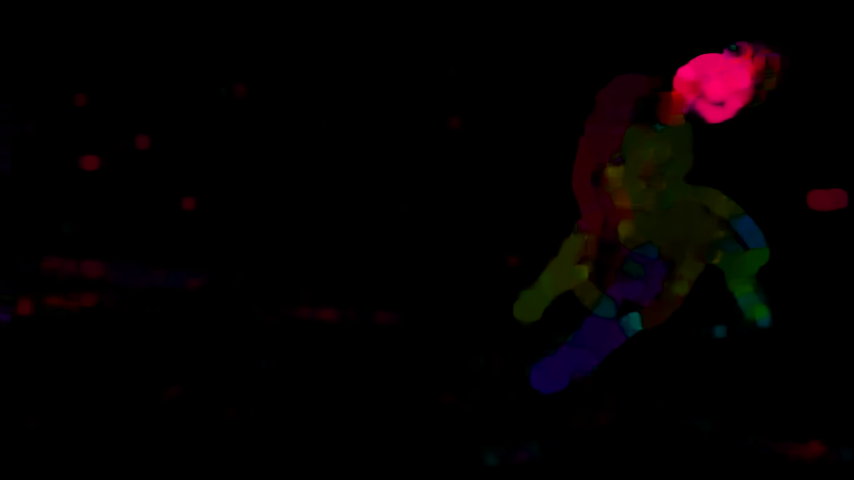

In [ ]:
flow_image = get_flow(my_frames[0], my_frames[1], 10)

cv2_imshow(flow_image)

kick.release()
cv2.destroyAllWindows()

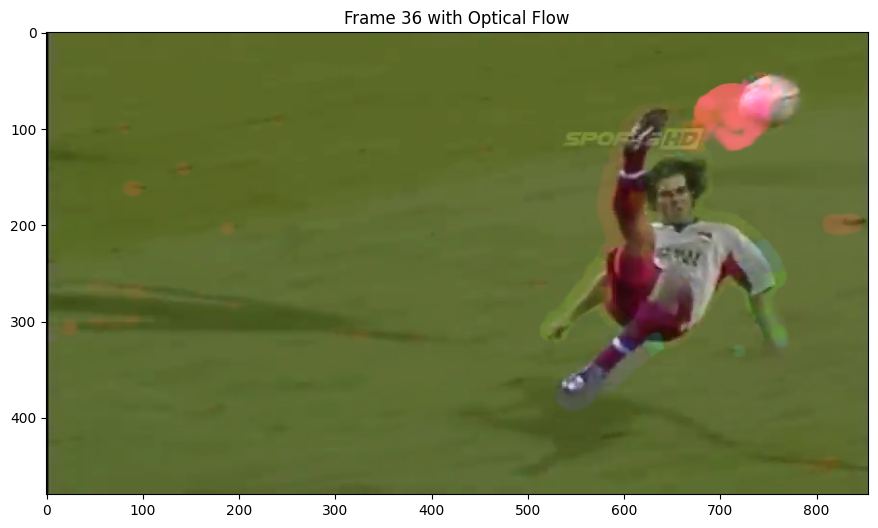

In [ ]:
result = cv2.addWeighted(my_frames[1], 0.8, flow_image, 0.6, 0)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Frame 36 with Optical Flow');

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

Win_size: 3


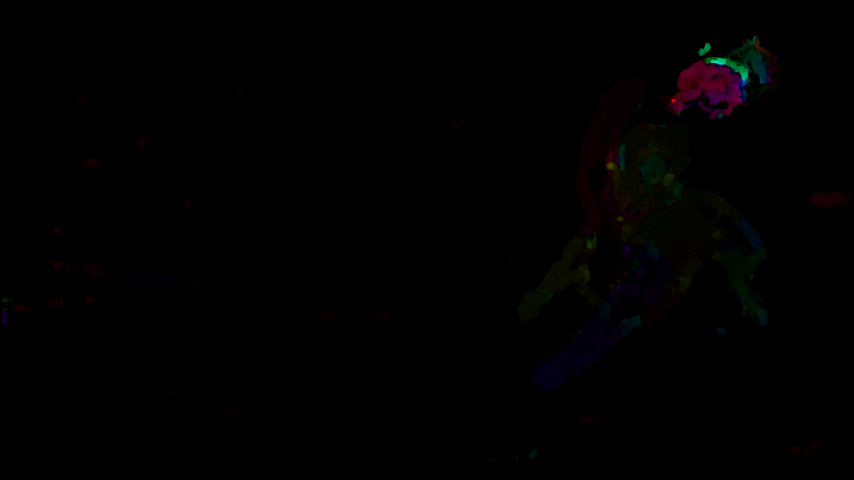

Win_size: 5


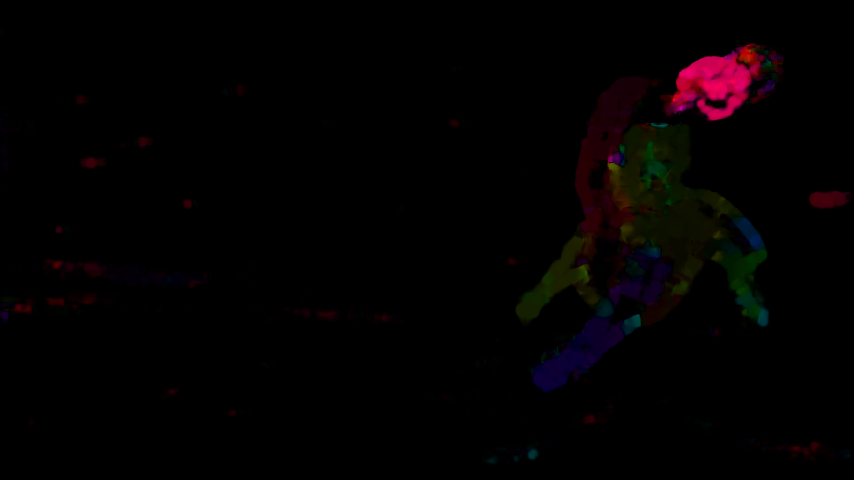

Win_size: 10


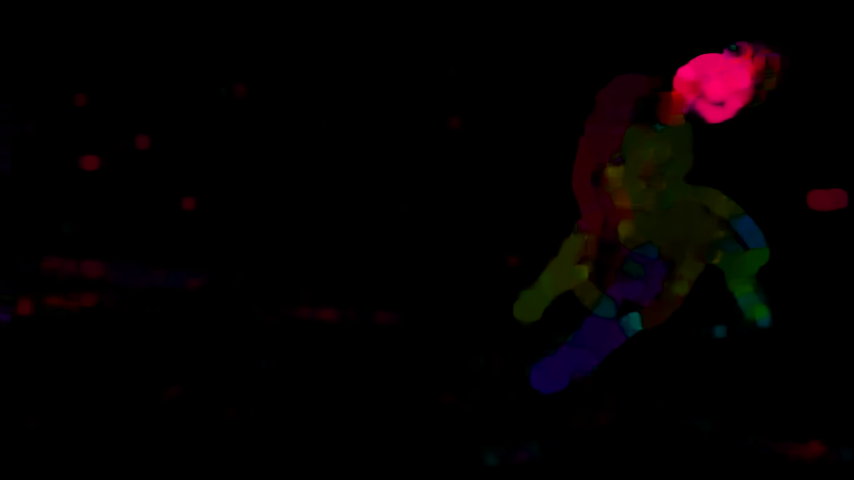

Win_size: 15


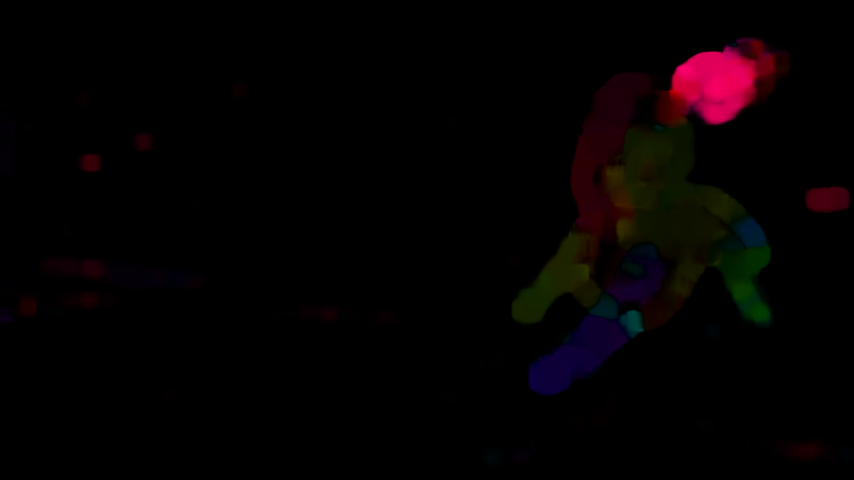

Win_size: 20


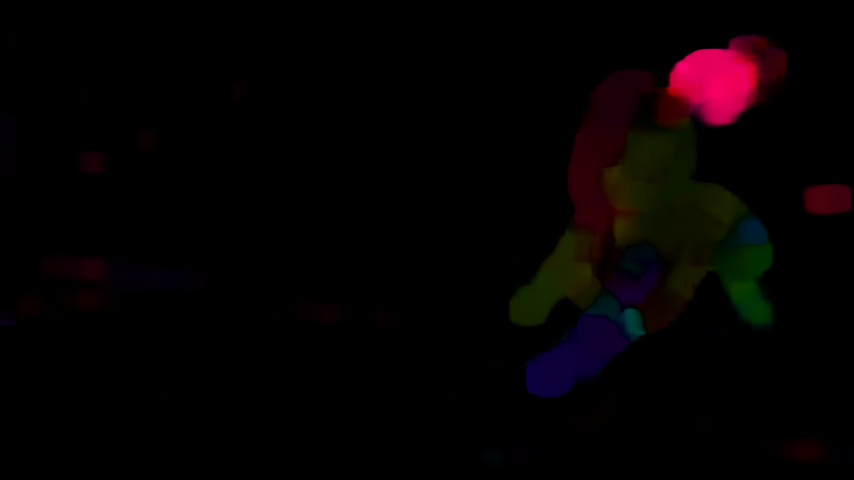

Win_size: 25


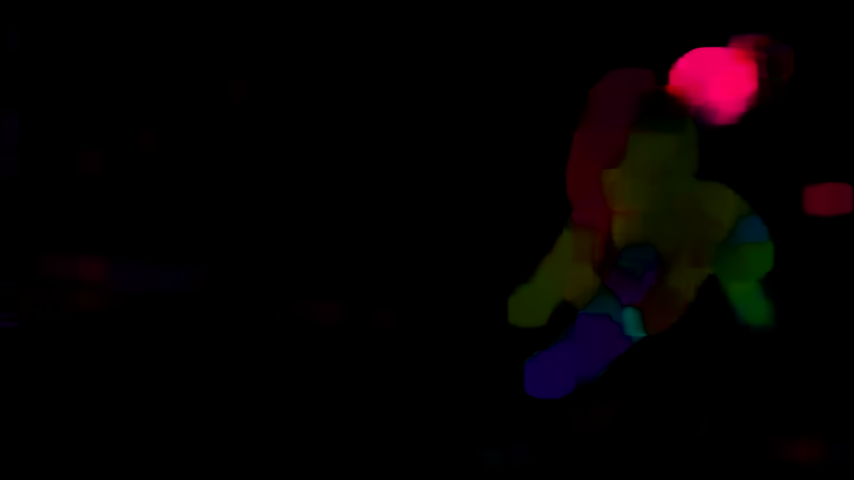

Win_size: 30


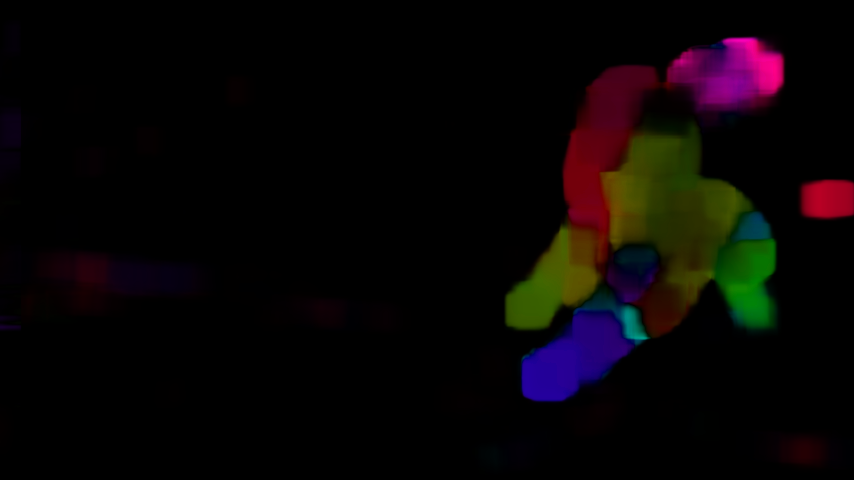

Win_size: 50


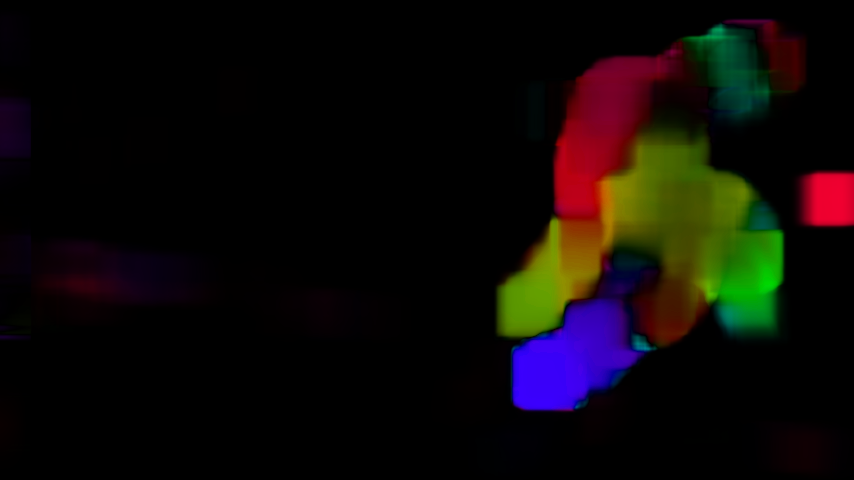

In [ ]:
win_sizes = [3, 5, 10, 15, 20, 25, 30, 50]

for winsize in win_sizes:

      flow_image = get_flow(my_frames[0], my_frames[1], winsize)


      print(f'Win_size: {winsize}')
      cv2_imshow(flow_image)

      kick.release()
      cv2.destroyAllWindows()

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

In [ ]:
shot = cv2.VideoCapture('/content/gdrive/MyDrive/APOW/Last_lab/videos/shot.mp4')
nr = 1
my_frames_2 = []

while(1):
    ret, frame = shot.read()

    if ret:
      print(f'Nr klatki: {nr}')
      cv2_imshow(frame)
    else:
      break

    if nr == 21 or nr == 22:
      my_frames_2.append(frame)

    nr+=1

shot.release()
cv2.destroyAllWindows()

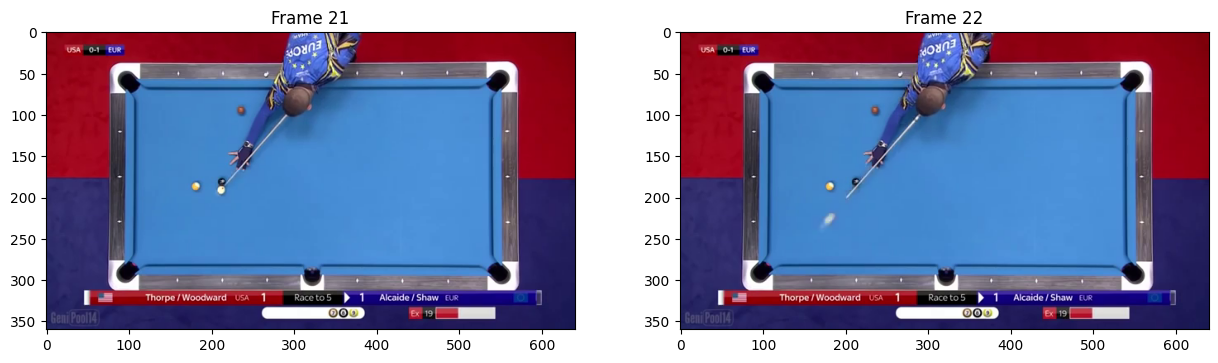

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].imshow(cv2.cvtColor(my_frames_2[0], cv2.COLOR_BGR2RGB))
axs[0].set_title('Frame 21')

axs[1].imshow(cv2.cvtColor(my_frames_2[1], cv2.COLOR_BGR2RGB))
axs[1].set_title('Frame 22');

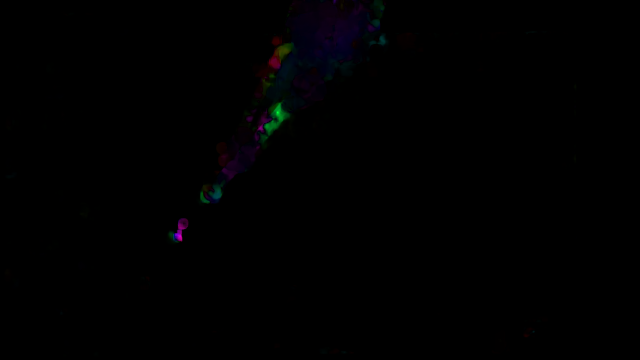

In [ ]:
flow_image = get_flow(my_frames_2[0], my_frames_2[1], 5)

cv2_imshow(flow_image)

kick.release()
cv2.destroyAllWindows()

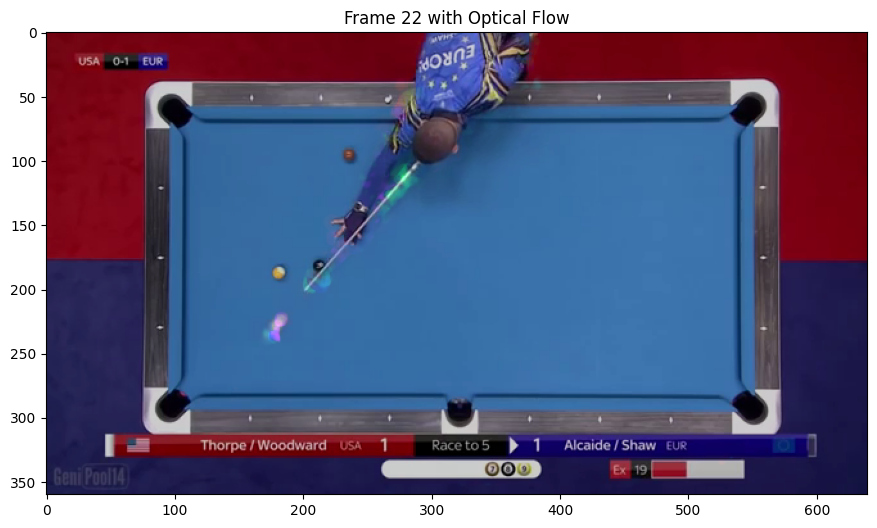

In [ ]:
result = cv2.addWeighted(my_frames_2[1], 0.8, flow_image, 0.6, 0)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Frame 22 with Optical Flow');

Komentarz 2:

...

### Zadanie dodatkowe

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).

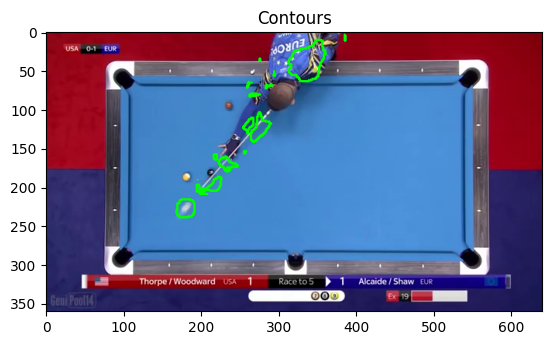

In [ ]:
flow = cv2.calcOpticalFlowFarneback(
    cv2.cvtColor(my_frames_2[0], cv2.COLOR_BGR2GRAY),
    cv2.cvtColor(my_frames_2[1], cv2.COLOR_BGR2GRAY),
    None, 0.5, 3, 15, 3, 5, 1.2, 0
)

mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

mask = mag > 2

contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(my_frames_2[1], contours, -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(my_frames_2[1], cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.show()